

# Fundamentals of Data Science - Week 2 and Week 3

###  <span style='color: green'>Scroll down to the bottom of the notebook to see your assignment</span> 
<p></p>
<span style='color: red'>Deadline: **27.09.2017 (Wednesday) at 23:55 CEST**</span>


In this notebook we are going to cover the following practical aspects of data science:
+ Gathering data (scraping the Twitter Streaming API)
+ Storing and organizing it (store to file or a database)
+ Preprocess the data
+ Perform sentiment, topical and correlation analysis
+ Visualize

To complete this assignment you need to have a running Anaconda installation with Python 2.7 on your device. If this is not the case, refer back to Week 1. Python package prerequisites include:
+  **Twitter API Client** [Tweepy](https://github.com/tweepy/tweepy) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [Install command: **pip install tweepy**]
+  **Python Data Analysis Library** [Pandas](https://pandas.pydata.org/pandas-docs/stable/install.html)  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  [Install command: **pip install pandas**]
+  **Python Visualization Library** [MatPlotLib](https://matplotlib.org/)   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [Install command: **python -m pip install matplotlib**]
+  **Python-Mongo Database Client** [PyMongo](https://api.mongodb.com/python/current/)  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  [Install command: **python -m pip install pymongo**]
+  **Python Topic Modelling Library** [GENISM](https://radimrehurek.com/gensim/install.html) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  [Install command: **pip install --upgrade gensim**]

An additional requirement if **you would like to use a database** is MongoDB:
+ MongoDb database server instance [MongoDb Installation Instructions](https://docs.mongodb.com/manual/tutorial/install-mongodb-on-ubuntu/#install-mongodb-community-edition)

** MongoDB stuff **

If MongoDB is installed on your device and a database named Twitter is created, the tweets can be stored as database entries using the following code:

**Note**: If Mongo is not installed on your device it will yield a Connection Refused exception.

In [1]:
from pymongo import MongoClient

client = MongoClient()
db = client.Twitter
#db = client.tweets_sample


In [2]:
from pprint import pprint

In [3]:
import pandas as pd
import geopandas as gpd

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import time

# Load necessary data from MongoDB

In [6]:
start_time = time.time()
#we are filtering out tweets of different languages and outside of the US
filter_query = { 
    "$and":[ {"place.country_code":"US"}, { "lang": "en" } ]
    }
#we are keeping only our fields of interest
columns_query = {
    'text':1,
    'entities.hashtags':1,
    'entities.user_mentions':1,
    'place.full_name':1,
    'place.bounding_box':1
}

tweets = pd.DataFrame(list(db.tweets.find(
    filter_query, 
    columns_query
    )#.limit()
                               )
                          )
elapsed_time = time.time() - start_time
print elapsed_time


19.6721830368


In [7]:
tweets.drop(['_id'],axis=1,inplace=True)

In [8]:
tweets.head()

,entities,place,text
0,"{u'user_mentions': [{u'id': 813286, u'indices'...","{u'bounding_box': {u'type': u'Polygon', u'coor...",@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...
1,"{u'user_mentions': [], u'hashtags': [{u'indice...","{u'bounding_box': {u'type': u'Polygon', u'coor...",#CNN #newday clear #Trump deliberately throwin...
2,"{u'user_mentions': [{u'id': 4852163069, u'indi...","{u'bounding_box': {u'type': u'Polygon', u'coor...",@mike4193496 @realDonaldTrump I TOTALLY CONCUR...
3,"{u'user_mentions': [{u'id': 1339835893, u'indi...","{u'bounding_box': {u'type': u'Polygon', u'coor...",@HillaryClinton you ARE the co-founder of ISIS...
4,"{u'user_mentions': [{u'id': 25073877, u'indice...","{u'bounding_box': {u'type': u'Polygon', u'coor...","@realDonaldTrump, you wouldn't recognize a lie..."


In [9]:
print len(tweets)

517724


** Extract data we need into their own columns (links, mentions, hashtags) **

* Deal with hyperlinks 

In [10]:
import re

# A function that extracts the hyperlinks from the tweet's content.
def extract_link(text):
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    match = re.search(regex, text)
    if match:
        return match.group()
    return ''

# A function that checks whether a word is included in the tweet's content
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

In [11]:
tweets['link'] = tweets['text'].apply(lambda tweet: extract_link(tweet))

In [12]:
#remove links
tweets['text'] = tweets['text'].apply(lambda tweet: re.sub(r"http\S+", "", tweet))

* Deal with hashtags & mentions

In [13]:
#Functions to extract hashtags and mentions from entities
def extract_hashtags(ent):
    a=[]
    [a.append(hasht['text'].lower()) for hasht in ent['hashtags']]
    #[a.append(hasht['text']) for hasht in ent['hashtags']]
    return a
def extract_mentions(ent):
    users=[]
    [users.append(usr_ment['screen_name'].lower()) for usr_ment in ent['user_mentions']]
    #[users.append(usr_ment['screen_name']) for usr_ment in ent['user_mentions']]
    return users

In [14]:
tweets['hashtags'] = map(extract_hashtags,tweets['entities'])
tweets['mentions'] = map(extract_mentions,tweets['entities'])
tweets.drop(['entities'],axis=1,inplace=True)

In [15]:
tweets['state'] = map(lambda place_dict: place_dict['full_name'][-2:] ,tweets['place'])
tweets['geography'] = map(lambda place_dict: place_dict['bounding_box'] ,tweets['place'])
tweets.drop(['place'],axis=1,inplace=True)

In [16]:
#make all text lowercase
tweets['text'] = tweets.text.apply(lambda x: x.lower())

In [17]:
tweets.columns

Index([u'text', u'link', u'hashtags', u'mentions', u'state', u'geography'], dtype='object')

# efforts with SentiStrength

In [18]:
#SentiStrength
import subprocess
jar_path = "/home/antonis/sentistrength/SentiStrength.jar"
senti_data_path = "/home/antonis/sentistrength/SentiData/"

In [19]:
#define a SentiStrength function which takes a string or tokenized input and returns sentiment scores
## TODO : caution: may be slow! (using ''.join )
sample_text = 'this is something'
def SentiStrength(sample_text):
    '''Returns a list of [positive, negative] values'''
    if type(sample_text) is str:
        return subprocess.check_output(['java', '-jar', jar_path, 'sentidata', senti_data_path ,'text',sample_text]).split()
    else:
        return subprocess.check_output(['java', '-jar', jar_path, 'sentidata', senti_data_path ,'text','+'.join(sample_text)]).split()

# Use externally trained model

### IMPORTANT:
#### we should use the same vectorizer as in the trained instance of the classifier our training and prediction matrices have to be the same


In [21]:
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import random

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


stemmer = SnowballStemmer('english')
analyzer = CountVectorizer().build_analyzer()


* Externally trained NaiveBayes classifier on 67k tweets

In [22]:
#import the model
from sklearn.externals import joblib

import pickle
clf = joblib.load('trained models/NaiveBayes67k_chi2descr9-26_22,52.pkl') #the model itself
selector = joblib.load("trained models/selector_chi267k_chi2descr9-26_22,52.pkl") #chi2 feature selector
vect = joblib.load('trained models/vectdescr9-26_22,52.pkl') #Countvectorizer along with its vocabulary

In [23]:
from nltk import tokenize

In [24]:
#rtransform our 
start_time = time.time()

results = clf.predict(selector.transform(vect.transform(tweets['text'])))

elapsed_time = time.time() - start_time
print elapsed_time

102.259329081


In [25]:
#try with probability!
start_time = time.time()

results_prob = clf.predict_proba(selector.transform(vect.transform(tweets['text'])))

elapsed_time = time.time() - start_time
print elapsed_time

112.642943859


In [26]:
results = pd.Series(results)
results_prob = pd.DataFrame(results_prob,columns=['negative','positive'])

In [27]:
tweets['NB'] = pd.Series(results)
tweets['NB_prob+'] = pd.Series(results_prob['positive'])

In [28]:
tweets.head()

,text,link,hashtags,mentions,state,geography,NB,NB_prob+
0,@barackobama \n@fbi\n@lorettalynch \nall in co...,https://t.co/5GMNZq40V3,"[nojustice, trumppence]","[barackobama, fbi, lorettalynch, realdonaldtrump]",LA,"{u'type': u'Polygon', u'coordinates': [[[-91.2...",0,0.268989
1,#cnn #newday clear #trump deliberately throwin...,,"[cnn, newday, trump, isis]",[],MD,"{u'type': u'Polygon', u'coordinates': [[[-76.7...",0,0.200862
2,@mike4193496 @realdonaldtrump i totally concur...,,[],"[mike4193496, realdonaldtrump]",MD,"{u'type': u'Polygon', u'coordinates': [[[-76.5...",0,0.059660
3,@hillaryclinton you are the co-founder of isis...,,[],[hillaryclinton],TX,"{u'type': u'Polygon', u'coordinates': [[[-97.0...",1,0.965413
4,"@realdonaldtrump, you wouldn't recognize a lie...",https://t.co/pKSQM8yikm,[nevertrump],[realdonaldtrump],CA,"{u'type': u'Polygon', u'coordinates': [[[-116....",1,0.936727


In [35]:
# manually inspect some results
for i in range(1,5):
    j = random.randint(0,len(tweets))
    tw = tweets['text'][j]
    print tw, '\n',tweets.ix[j,'NB_prob+'],' positive'
    print ''

@hughhewitt @noltenc @realdonaldtrump hugh, you're right. #basketoofdeplorables he'll hit again, and again. 
0.86193296115  positive

@karoli @davidshuster @hillaryclinton david might have deleted that after properly put him in line 
0.320181959525  positive

@realdonaldtrump and, btw, no need to look at my tax returns 
0.331246620146  positive

@realdonaldtrump do we need driver license at bank? yes. do we need driver license to take exams? yes. do we need driver license to vote? no 
0.416220810491  positive



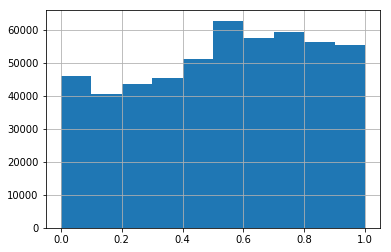

In [37]:
#check the distribution of our probability estimates of the tweets
tweets['NB_prob+'].hist()
plt.show()

##### investigate the possibility of introducing a 'neutral' sentiment class


In [39]:
sa_results = map(lambda x: 'positive' if x>0.7 else 'negative' if x<0.3 else 'neutral' , tweets['NB_prob+'])

In [40]:
sa_results = pd.Series(sa_results)

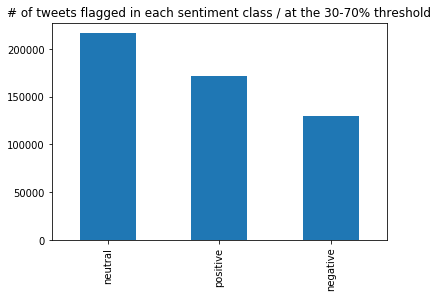

In [41]:
sa_results.value_counts().plot(kind='bar', title='# of tweets flagged in each sentiment class / at the 30-70% threshold')
plt.show()

In [42]:
tweets.head()

,text,link,hashtags,mentions,state,geography,NB,NB_prob+
0,@barackobama \n@fbi\n@lorettalynch \nall in co...,https://t.co/5GMNZq40V3,"[nojustice, trumppence]","[barackobama, fbi, lorettalynch, realdonaldtrump]",LA,"{u'type': u'Polygon', u'coordinates': [[[-91.2...",0,0.268989
1,#cnn #newday clear #trump deliberately throwin...,,"[cnn, newday, trump, isis]",[],MD,"{u'type': u'Polygon', u'coordinates': [[[-76.7...",0,0.200862
2,@mike4193496 @realdonaldtrump i totally concur...,,[],"[mike4193496, realdonaldtrump]",MD,"{u'type': u'Polygon', u'coordinates': [[[-76.5...",0,0.059660
3,@hillaryclinton you are the co-founder of isis...,,[],[hillaryclinton],TX,"{u'type': u'Polygon', u'coordinates': [[[-97.0...",1,0.965413
4,"@realdonaldtrump, you wouldn't recognize a lie...",https://t.co/pKSQM8yikm,[nevertrump],[realdonaldtrump],CA,"{u'type': u'Polygon', u'coordinates': [[[-116....",1,0.936727


# attach tweet to politician

In [43]:
def trump_in_text(tweet):
        '''This function takes the text of a tweet and 
            returns true if there is a mention to  Donald Trump or false 
            on the other hand.'''
        if ('donald' in tweet.lower()) or ('trump'  in tweet.lower()):
            return True
        return False
    
def clinton_in_text(tweet):
        '''This function takes the text of a tweet and 
            returns true if there is a mention to  Hillary Clinton  or false 
            on the other hand.'''

        if ('hillary' in tweet.lower()) or ('clinton'  in tweet.lower()):
            return True
        return False

def categorize(tr,hil):
        '''This function  categorizes each tweet based
           on text '''
        if tr==hil:
            return 'irrelevant'
        elif tr:
            return 'Trump'
        else:
            return'Clinton'


In [45]:
tweets['Trump'] = tweets['text'].apply(lambda tweet: trump_in_text(tweet))
tweets['Clinton'] = tweets['text'].apply(lambda tweet: clinton_in_text(tweet))
tweets['Politician']=map(lambda tr_col, hil_col: categorize(tr_col, hil_col), tweets['Trump'],tweets['Clinton'])

In [46]:
tweets.drop(['Trump','Clinton','geography'],axis=1,inplace=True)

In [47]:
tweets.head()

,text,link,hashtags,mentions,state,NB,NB_prob+,Politician
0,@barackobama \n@fbi\n@lorettalynch \nall in co...,https://t.co/5GMNZq40V3,"[nojustice, trumppence]","[barackobama, fbi, lorettalynch, realdonaldtrump]",LA,0,0.268989,Trump
1,#cnn #newday clear #trump deliberately throwin...,,"[cnn, newday, trump, isis]",[],MD,0,0.200862,Trump
2,@mike4193496 @realdonaldtrump i totally concur...,,[],"[mike4193496, realdonaldtrump]",MD,0,0.059660,Trump
3,@hillaryclinton you are the co-founder of isis...,,[],[hillaryclinton],TX,1,0.965413,Clinton
4,"@realdonaldtrump, you wouldn't recognize a lie...",https://t.co/pKSQM8yikm,[nevertrump],[realdonaldtrump],CA,1,0.936727,Trump


In [48]:
tweets.Politician.unique()

array(['Trump', 'Clinton', 'irrelevant'], dtype=object)

In [49]:
#### give a label to each tweet (ex. pro-Trump / anti-Hillary etc)
def label_tweet(pol,sent, upper_threshold=0.5):
    '''Label tweet depending on politician and sentiment.
    Return neutral if politician unknown or Naive Bayes prob close to 0.5
    otherwise return Politician initials and +/-'''
    if (((sent<upper_threshold) and (sent>(1-upper_threshold))) or (pol=='irrelevant')):
        return 'N'
    if (pol=='Trump'):
        label='T'
    if (pol=='Clinton'):
        label='C'
    if (sent>0.5):
        return label+'+'
    if (sent<0.5):
        return label+'-'
    return 'error'

In [50]:
tweets['label'] = map(lambda name,sent: label_tweet(name,sent) ,tweets['Politician'],tweets['NB_prob+'])

In [51]:
tweets.head()

,text,link,hashtags,mentions,state,NB,NB_prob+,Politician,label
0,@barackobama \n@fbi\n@lorettalynch \nall in co...,https://t.co/5GMNZq40V3,"[nojustice, trumppence]","[barackobama, fbi, lorettalynch, realdonaldtrump]",LA,0,0.268989,Trump,T-
1,#cnn #newday clear #trump deliberately throwin...,,"[cnn, newday, trump, isis]",[],MD,0,0.200862,Trump,T-
2,@mike4193496 @realdonaldtrump i totally concur...,,[],"[mike4193496, realdonaldtrump]",MD,0,0.059660,Trump,T-
3,@hillaryclinton you are the co-founder of isis...,,[],[hillaryclinton],TX,1,0.965413,Clinton,C+
4,"@realdonaldtrump, you wouldn't recognize a lie...",https://t.co/pKSQM8yikm,[nevertrump],[realdonaldtrump],CA,1,0.936727,Trump,T+


# export for each state

In [52]:
from data.US_states import states

In [53]:
#initialize a df indexed by label values
state_sentiment = pd.DataFrame(index=tweets.label.unique())

In [54]:
for state in states.keys():
    state_sentiment[state] = tweets[tweets['state']==state]['label'].value_counts()
state_sentiment = state_sentiment.transpose()

In [55]:
state_sentiment.describe()

,T-,C+,T+,C-,N
count,51.000000,51.000000,51.000000,51.000000,51.000000
mean,1708.549020,830.196078,2367.372549,667.294118,1922.568627
std,2498.403181,1160.520418,3417.309076,931.886802,2717.523522
min,51.000000,27.000000,74.000000,25.000000,43.000000
25%,397.000000,227.000000,521.000000,154.000000,461.500000
50%,715.000000,399.000000,1264.000000,312.000000,1036.000000
75%,1938.000000,976.000000,2621.000000,842.500000,2158.000000
max,13842.000000,6388.000000,18079.000000,5082.000000,14284.000000


In [56]:
state_sentiment.head()

,T-,C+,T+,C-,N
WA,2276,1027,3150,833,2300
WI,687,331,1332,286,1281
WV,291,81,430,44,161
FL,7685,3595,10974,3100,9331
WY,51,56,119,49,71


In [155]:
pickle.dump(state_sentiment,open('results/state_sentiment_0.5.pickle','wb'))

# Investigate tweets using hashtags

In [93]:
def get_sentiment_from_hashtag(hashtag_list,
                               anti_trump_list=set(['nevertrump','dumptrump']), anti_hillary_list=set(['lockherup']),
                               pro_trump_list=set(['trumptrain']), pro_hillary_list=set(['imwithher'])
                              ):
    '''Given a list of hashtags, classify the tweet positively (1), neutral (0) or negatively(-1)'''
    hashtag_list = set(hashtag_list)
    pro_trump=anti_trump=pro_hillary=anti_hillary = False
    negative=positive = False
    if (len(hashtag_list.intersection(anti_trump_list))>0) | (len(hashtag_list.intersection(anti_hillary_list))>0):
        negative = True
    
    if (len(hashtag_list.intersection(pro_hillary_list))>0) | (len(hashtag_list.intersection(pro_trump_list))>0):
        positive = True

    if positive == negative:
        return 0 #both negative+positive hashtags
    if positive:
        return 1
    if negative:
        return -1
    return 0 #no 'explanatory' hashtag found

In [97]:
#test our function
print get_sentiment_from_hashtag(['lockherup', 'trumptrain'])
print get_sentiment_from_hashtag(['lockherup', 'dumptrump'])

0
-1


In [102]:
np.unique([tweets.hashtags.apply(lambda x: get_sentiment_from_hashtag(x))])

array([-1,  0,  1])

In [106]:
tweets['sentiment_hashtag'] = tweets.hashtags.apply(lambda x: get_sentiment_from_hashtag(x))

In [107]:
tweets.head()

,text,link,hashtags,mentions,state,NB,NB_prob+,Politician,label,sentiment_hashtag
0,@barackobama \n@fbi\n@lorettalynch \nall in co...,https://t.co/5GMNZq40V3,"[nojustice, trumppence]","[barackobama, fbi, lorettalynch, realdonaldtrump]",LA,0,0.268989,Trump,T-,0
1,#cnn #newday clear #trump deliberately throwin...,,"[cnn, newday, trump, isis]",[],MD,0,0.200862,Trump,T-,0
2,@mike4193496 @realdonaldtrump i totally concur...,,[],"[mike4193496, realdonaldtrump]",MD,0,0.059660,Trump,T-,0
3,@hillaryclinton you are the co-founder of isis...,,[],[hillaryclinton],TX,1,0.965413,Clinton,C+,0
4,"@realdonaldtrump, you wouldn't recognize a lie...",https://t.co/pKSQM8yikm,[nevertrump],[realdonaldtrump],CA,1,0.936727,Trump,T+,-1


# Benchmark my classifier on negative hashtag tweets

In [116]:
negative_tweets = clf.predict(selector.transform(vect.transform(tweets.text[tweets.sentiment_hashtag==-1])))
negative_idx = tweets.text[tweets.sentiment_hashtag==-1].index

In [117]:
for i in range(1,5):
    j = random.randint(0,len(negative_idx))
    print tweets.ix[j,'NB_prob+'],tweets.text[j],'\n'

0.998751269877 @dds_officer thx 4 the follow. i look 4ward 2 learning n 2 sharing. best, nick. pls visit me at www.  #nevertrump 

0.714839142351 @rogerjstonejr how is the best dressed man in nyc tonight? wishing you well and praying for you tonight. #maga 

0.070043121167 i hope they release everything soon. i think she'll have 2 quit due to illness, but either way we need to go.   

0.367458973798 all of you so called #conservatives will be putting a lib dem to appoint if you don't vote #trump.  it's more than 4 years at stake #gop 



/home/antonis/anaconda2/envs/USelections/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


In [118]:
pd.Series(negative_tweets).value_counts()

1    10429
0     8468
dtype: int64

### We can see that there is a problem in our sentiment classifier, as we would expect it to label more tweets negatively
We should investigate ways to improve it, such as train on a political corpus dataset, use bigrams etc. For more on that, please check the discussion section in our assignment.